In [74]:
import sys
sys.path.append("/Users/lanag/Downloads/svise-tutorials")
import svise
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import rc
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchsde import sdeint as torchsdeint
from tqdm import tqdm

from svise import sde_learning, sdeint

rc('text', usetex=False)
torch.set_default_dtype(torch.float64)

In [75]:
#load data
import pandas as pd
import numpy as np
Xdata = pd.read_csv('/Users/lanag/Downloads/svise-tutorials2/comparison/Lorenz_x_stochastic_gamma075_withlib_svise.csv',header = None)
Xdata_value = Xdata.values
timelen = Xdata_value.shape[0]
#tspan = pd.read_csv('/Users/lanag/Downloads/svise-tutorials2/comparison/Lorenztspan_gamma05.csv',header = None)
T = 20
dt = 0.01

tspan = np.linspace(0.01,T,int(T/dt))
d = 6

In [76]:
Xdata_value = torch.tensor(Xdata_value).clone().detach()
tspan = torch.tensor(tspan).clone().detach()

In [77]:
def generate_data(data_value, t_eval, train_persentage):
    data = dict(t=t_eval, true_state=data_value)
    data["y"] = data_value @ G.T
    data["y"] += torch.randn_like(data["y"]) * std
    data["train_t"] = data["t"][0:int(train_persentage*t_eval.shape[0])]
    data["train_y"] = data["y"][0:int(train_persentage*t_eval.shape[0])]
    data["valid_t"] = data["t"][int(train_persentage*t_eval.shape[0]):]
    data["valid_state"] = data["true_state"][int(train_persentage*t_eval.shape[0]):]
    data["train_state"] = data["true_state"][0:int(train_persentage*t_eval.shape[0])]
    return data

Text(0, 0.5, 'latent state')

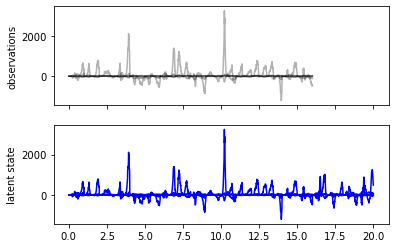

In [78]:
# observation function
#G = torch.randn(2,2) + torch.eye(2)
G = torch.eye(6)
std = 1e-5

data = generate_data(Xdata_value, tspan, 0.8)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(data["train_t"], data["train_y"].numpy(), "k-", label="training data", alpha=0.3)
ax[0].set_ylabel("observations")
ax[1].plot(data["t"], data["true_state"].numpy(), 'b-', label='latent state')
ax[1].set_ylabel("latent state")

In [79]:
t_span = (data["train_t"].min(), data["train_t"].max())
d = 6 # dimension of the latent state
degree = 2 # degree of polynomial terms
n_reparam_samples = len(data["train_t"]) # how many reparam samples
var = (torch.ones(d) * std) ** 2
num_data = len(data["train_t"])

model = sde_learning.SparsePolynomialSDE(
    d, 
    t_span, 
    degree=degree, 
    n_reparam_samples=n_reparam_samples, 
    G=G, 
    num_meas=d, 
    measurement_noise=var, 
    train_t=data["train_t"], 
    train_x=data["train_y"],
    input_labels=["x", "y", "z", "xj","xixj","xjminusxi"],
)

In [81]:
#recorded_models = []

In [82]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)
batch_size = min(len(data['train_t']), 128)
train_loader = DataLoader(TensorDataset(data["train_t"], data["train_y"]), batch_size=batch_size, shuffle=True)

# sparse learning takes a long time to converge
num_epochs = 200 #1000
warmup_iters = num_epochs // 2

import time
start = time.time()
j=0
for epoch in tqdm(range(1,num_epochs+1)):
    j += 1
    beta = min(1.0, j / warmup_iters)
    for tbatch, ybatch in train_loader:
        optimizer.zero_grad()
        loss = -model.elbo(tbatch, ybatch, beta=beta,  N=num_data)
        #loss = model.elbo(nsde_args["train_t"], nsde_args["train_x"], beta=1.0, N = 100)
        loss.backward()
        optimizer.step()
    #model.cpu()
    #from copy import deepcopy as copy
    #recorded_models.append(model.state_dict())
end = time.time()

print('Time consuming:', end - start)

100%|█████████████████████████████████████████| 200/200 [26:49<00:00,  8.05s/it]

Time consuming: 1609.2116661071777


In [85]:
model.eval()
model.sde_prior.reset_sparse_index()
model.sde_prior.update_sparse_index()
var_names = ["x", "y", "z", "xj","xixj","xjminusxi"]
for j, eq in enumerate(model.sde_prior.feature_names):
    print(f"d{var_names[j]} = {eq}")

dx = -8.56x + 6.93y + 0.36xj + 0.05xixj + -0.03y z + -0.01y xj + 0.00y xixj + -0.01z xj + -0.01xj^2
dy = 6.931 + 0.31x + 7.41y + 1.61xj + 0.03xixj + -0.08x^2 + -0.34x z + 0.02y^2 + -0.20y z + -0.04y xj + 0.00y xixj + -0.02z xj + 0.00z xixj + 0.00xj^2 + -0.00xj xixj + 0.00xj xjminusxi + -0.00xixj^2
dz = -53.391 + 0.53x + -5.13z + 0.48x y + -0.01x z + -0.02x xj + 0.16y^2 + 0.09y xj + 0.00y xixj + -0.02y xjminusxi + -0.01z xj + 0.00z xjminusxi + -0.00xj xixj + 0.00xj xjminusxi + -0.00xixj^2 + -0.00xixj xjminusxi
dxj = 5.371 + -2.16x + 2.34y + -0.01xixj + 0.05xjminusxi + -0.11x y + -0.01x xixj + 0.05x xjminusxi + 0.01y^2 + -0.06y z + -0.02y xj + 0.02y xixj + -0.03y xjminusxi + -0.04z xj + -0.00z xixj + 0.01z xjminusxi + 0.00xj xixj + -0.01xj xjminusxi + 0.00xixj^2 + -0.00xixj xjminusxi
dxixj = -18.951 + -14.23y + -7.23z + -4.76xixj + -6.52xjminusxi + 1.36x xjminusxi + -0.10y^2 + 12.23y xj + 0.03y xixj + -1.64y xjminusxi + -1.54z xj + -0.18z xixj + 0.47z xjminusxi + 0.49xj^2 + 0.02xj xixj +

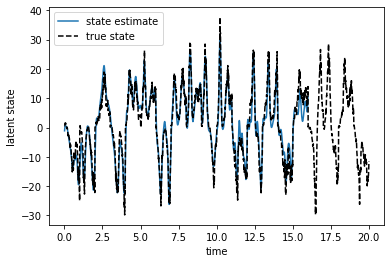

In [86]:

state_true = data
with torch.no_grad():
    # get the state estimate
    mu = model.marginal_sde.mean(state_true["train_t"])
    var = model.marginal_sde.K(state_true["train_t"]).diagonal(dim1=-2, dim2=-1)
    lb = mu - 2 * var.sqrt()
    ub = mu + 2 * var.sqrt()

# plot the results
fig, ax = plt.subplots()
ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,0], 'C0', label='state estimate')
#ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,1], 'C0')
ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,0], 'k--', label='true state')
#ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,1], 'k--')

ax.set_xlabel("time")
ax.set_ylabel("latent state")
ax.legend()
plt.savefig('Lorenz_2nodes_noise075.pdf')